In [1]:
import findspark
from pyspark import SparkContext
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

findspark.init()
sc = SparkContext("local[*]", "Name of the Program")

23/10/16 10:03:54 WARN Utils: Your hostname, vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/10/16 10:03:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/10/16 10:03:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
def readFile(filename : str = 'botnet_tot_syn_l.csv'):
    '''
    filename -- name of the spam dataset file
        
    returns:
        An Rdd containing the data of filename. 
            Each element is a tuple (X,y).
                “X” is an array containing the 11 features (float number) of an example
                “y” is the 12th column of an example (integer 0/1)
    '''
    
    print(f"Getting input data from file: {filename}")
    rdd_Xy = sc.textFile(filename)
    
    def formatSamples(row):
        aux_arr = np.array(row.split(','), dtype=float)
        return (aux_arr[:-1], round(aux_arr[-1]))
    
    rdd_Xy = rdd_Xy.map(formatSamples)
    
    return rdd_Xy

In [3]:
def normalize (Rdd_Xy):
    '''
    Arguments:
        Rdd_Xy is an Rdd containing data examples. Each element is a tuple (X,y).
            “X” is an array containing the 11 features (float number) of an example
            “y” is the label of the example (integer 0/1)
    Returns:
        A numpy array rescaled to N(0,1) in each column (mean=0, standard deviation=1)
    '''
    
    if 'm' not in globals():
        print("Counting number of samples in dataset...")
        global m
        m = Rdd_Xy.count() # Number of rows (samples)
        print(f"There's a total of {m} elements in the dataset!\n")
        
    print("Dataset normalization in progress...\n")
    
    # Calculate mean array
    print("Calculating mean values...")
    mean_arr = Rdd_Xy.reduce(lambda x, y: (x[0] + y[0], 0)) # Label doesn't need to be accumulated
    mean_arr = mean_arr[0] # Remove label
    mean_arr /= m
    print(f"Calculated Mean: {mean_arr}\n")
    
    # Calculate stddev array
    print("Calculating stddev values...")
    rdd_variance = Rdd_Xy.map(lambda x: ( (x[0] - mean_arr)**2, 0) )
    variance_arr = rdd_variance.reduce(lambda x, y: (x[0] + y[0], 0)) # Label doesn't need to be accumulated
    variance_arr = variance_arr[0] # Remove label
    variance_arr /= m
    stddev_arr = np.sqrt(variance_arr)
    print(f"Calculated Stddev: {stddev_arr}\n")
    
    print("Normalizing...")
    Rdd_Xy_normalized = Rdd_Xy.map(lambda x: ((x[0] - mean_arr) / stddev_arr, x[1]))
    
    return Rdd_Xy_normalized

In [4]:
import numpy as np

def predict_prob (w, b, x):
    '''
    Auxiliary function! Returns predicted probabilities, NOT predicted labels
    
    Arguments:
        w -- weights
        b -- bias
        x -- Example to be predicted (only 1 example)
    Returns:
        Y_pred_prob -- a float value (0-1) corresponding to the prediction of X
    '''
    
    # Apply model's function
    y_logit = np.dot(w, x) + b
    
    # Apply sigmoid to get prediction probability
    y_pred_prob = 1 / (1 + np.exp(-y_logit)) 
    
    return y_pred_prob

In [5]:
import math
import pandas as pd
from tqdm.notebook import tqdm

NUM_FEATURES = 11
NUM_WEIGHTS = NUM_FEATURES + 1

def train (Rdd_Xy, iterations, learning_rate):
    '''
    Arguments:
        Rdd_Xy -- Rdd containing data examples. Each record of the array is a tuple (X,y).
            “X” is an array containing the 11 features (float number) of an example
            “y” is the label of the example (integer 0/1)
        iterations -- number of iterations of the optimization loop
        learning_rate -- learning rate of the gradient descent
    Returns:
        A list or array containing the weights “w” and bias “b” at the end of the
            training process in the shape of [w0, w1, ... w10, b]
    '''
    
    w = np.random.rand(NUM_WEIGHTS) # Weights
    
    if 'm' not in globals():
        print("Counting number of samples in dataset...")
        global m
        m = Rdd_Xy.count() # Number of rows (samples)
        
    cost_reg = []
    
    print("Training...")
    for it in tqdm(range(iterations), desc="Iterations: "):
        
        def map_cost_dw(x):
            X, y = x # Unpack tuple
            dw_ = np.zeros(NUM_WEIGHTS) # Derived weights
            
            # Get y_hat for one data sample
            y_pred_prob = predict_prob(w[:-1], w[-1], X) 
            
            # Prevent math errors
            epsilon=0.00000001
            if y_pred_prob <= 0:
                y_pred_prob = epsilon
            elif y_pred_prob >= 1:
                y_pred_prob = 1 - epsilon
            
            # Calculate single cost
            cost_ = y * math.log(y_pred_prob) + (1 - y) * math.log(1 - y_pred_prob)
            
            # Calculate derivative component of w
            dw_[:-1] = ( y_pred_prob - y ) * X
            dw_[-1] = y_pred_prob - y
            
            return (cost_, dw_)
        
        rdd_cost_dw = Rdd_Xy.map(map_cost_dw)
        cost, dw = rdd_cost_dw.reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
        
        # Divide by number of samples to compute the cost 
        cost /= -m
        cost_reg.append(cost)
        print(f"Iteration: {it} - Cost: {cost}")
        
        # Average derivative of w
        dw /= m
        
        # Update weights
        w -= learning_rate * dw
    
    # Plot cost curve
    df = pd.DataFrame({"Cost": cost_reg}, index=range(1, iterations + 1))
    df.plot(title="Training Cost", xlabel="Iterations")
        
    # Return tuned weights
    return w

In [6]:
import numpy as np

def predict (w, b, x):
    '''
    Arguments:
        w -- weights
        b -- bias
        x -- Example to be predicted (only 1 example)
    Returns:
        Y_pred -- a value (0/1) corresponding to the prediction of X
    '''
    
    # Apply model's function
    y_logit = np.dot(w, x) + b
    
    # Apply sigmoid to get prediction probability
    y_pred_prob = 1 / (1 + np.exp(-y_logit)) 
    
    # Round up to 0 or 1
    y_pred = 1 if y_pred_prob >= 0.5 else 0
    
    return y_pred

In [7]:
def accuracy (w, b, Rdd_Xy):
    '''    
    Arguments:
        w -- weights
        b -- bias
        Rdd_Xy -- rdd containing examples to be predicted
    Returns:
        accuracy -- the number of predictions that are correct divided by the number of 
            records (examples) in Xy.
    '''
    if 'm' not in globals():
        print("Counting number of samples in dataset...")
        global m
        m = Rdd_Xy.count() # Number of samples
        
    accuracy = 0
    
    print("\nCalculating accuracy...")
    def map_accuracy(x):
        X, y = x
        y_pred = predict(w, b, X)
        return 1 if y_pred == y else 0
    
    rdd_accuracy = Rdd_Xy.map(map_accuracy)
    accuracy = rdd_accuracy.reduce(lambda x, y: x + y)
    accuracy /= m
    
    return accuracy

# MAIN Code

Getting input data from file: botnet_tot_syn_l.csv
Counting number of samples in dataset...


There's a total of 1000000 elements in the dataset!

Dataset normalization in progress...

Calculating mean values...


Calculated Mean: [1.28153827e+03 2.12827672e+04 6.94805718e+03 6.26311961e+04
 1.22198595e+08 1.57222361e+07 9.10731393e+00 1.88975480e+00
 1.24270159e+02 2.13060301e+09 2.26149180e+09]

Calculating stddev values...


Calculated Stddev: [1.60589322e+03 2.41174750e+04 1.63949454e+04 1.34264218e+05
 2.33920714e+08 4.41237795e+07 5.28172581e+00 2.10134561e+00
 9.03431222e+01 7.13843443e+08 1.30153195e+09]

Normalizing...
Training...



[Stage 2:=============================================>             (7 + 2) / 9]



Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration: 0 - Cost: 1.83476515648635


Iteration: 1 - Cost: 0.9581154219742667


Iteration: 2 - Cost: 0.557545768513042


Iteration: 3 - Cost: 0.3975324852001241


Iteration: 4 - Cost: 0.32437923279065317


Iteration: 5 - Cost: 0.28454734272405907


Iteration: 6 - Cost: 0.2598391496905775


Iteration: 7 - Cost: 0.24308830379987342


Iteration: 8 - Cost: 0.23100665949192015


Iteration: 9 - Cost: 0.22189038969883715

Calculating accuracy...


Accuracy: 92.7318 %


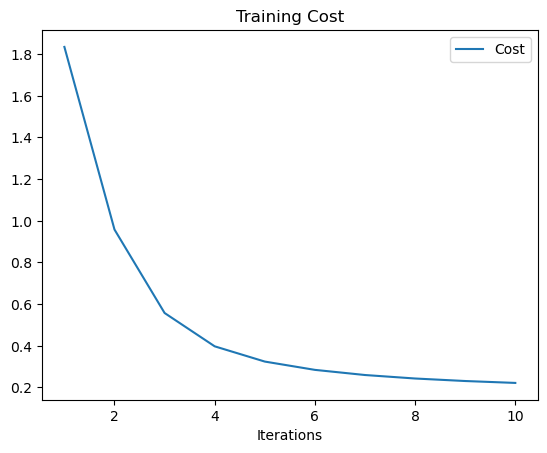

In [8]:
NUM_ITER = 10
LR = 1.5

# Read data from file
Rdd_Xy = readFile('botnet_tot_syn_l.csv')

# Normalize data
Rdd_Xy_normalized = normalize(Rdd_Xy)

# Train Model
w = train(Rdd_Xy_normalized, NUM_ITER, LR)

# Calculate Accuracy
acc = accuracy(w[:-1], w[-1], Rdd_Xy_normalized)
print(f"Accuracy: {(acc*100):.4f} %")